In [109]:
import torch.nn as nn
import torch
import torch.nn.functional as F

class BitLinear(nn.Linear):
    def __init__(self, in_features, out_features, bias=False, lora_rank=16):
        super(BitLinear, self).__init__(in_features, out_features, bias)
        self.gamma_forward = nn.Parameter(torch.randn(in_features), requires_grad=False)
        self.beta = nn.Parameter(torch.randn(out_features), requires_grad=False)
        self.epsilon = 1e-8

    def binarize(self, W):
        gamma = torch.sum(torch.abs(W)) / (W.shape[0] * W.shape[1])
        W = W / (gamma + self.epsilon)
        W_bin = torch.clamp(W, -1, 1).round()
        return W + (W_bin - W).detach()


    def forward(self, input):
        if input.dim() == 1:
            input = input.unsqueeze(0)

        input_norm = F.layer_norm(input, (self.in_features,))
        quant_scale = torch.max(torch.abs(input_norm), dim=1, keepdim=True).values
        input_quant = torch.sign(input_norm) * (quant_scale / self.gamma_forward)
        
        binary_weight = self.binarize(self.weight)

        output = torch.matmul(input_quant, binary_weight.t())
        output = output * self.beta.expand_as(output)

        return output

Loss: 90.09687805175781
Loss: 90.09687805175781
Loss: 90.09687805175781
Loss: 90.09687805175781
Loss: 90.09687805175781
Loss: 90.09687805175781
Loss: 90.09687805175781
Loss: 90.09687805175781
Loss: 90.09687805175781
Loss: 90.09687805175781


In [111]:
class BitLinear(nn.Linear):
    def __init__(self, in_features, out_features, bias=True, num_groups=1):
        super(BitLinear, self).__init__(in_features, out_features, bias)
        self.num_groups = num_groups
        self.eps = 1e-5

    def ste_binarize(self, x):
        # Apply the sign function for binarization
        binarized_x = torch.sign(x)
        # Use STE: during backward pass, we bypass the binarization
        binarized_x = (binarized_x - x).detach() + x
        return binarized_x

    def binarize_weights_groupwise(self):
        # Divide weights into groups
        group_size = self.weight.shape[0] // self.num_groups
        binarized_weights = torch.zeros_like(self.weight)

        for g in range(self.num_groups):
            start_idx = g * group_size
            end_idx = (g + 1) * group_size
            weight_group = self.weight[start_idx:end_idx]

            # Binarize each group using STE
            alpha_g = weight_group.mean()
            binarized_weights[start_idx:end_idx] = self.ste_binarize(
                weight_group - alpha_g
            )

        return binarized_weights

    def quantize_activations_groupwise(self, x, b=8):
        Q_b = 2 ** (b - 1)

        # Divide activations into groups
        group_size = x.shape[0] // self.num_groups
        quantized_x = torch.zeros_like(x)

        for g in range(self.num_groups):
            start_idx = g * group_size
            end_idx = (g + 1) * group_size
            activation_group = x[start_idx:end_idx]

            # Quantize each group
            gamma_g = activation_group.abs().max()
            quantized_x[start_idx:end_idx] = torch.clamp(
                activation_group * Q_b / (gamma_g + self.eps),
                -Q_b + self.eps,
                Q_b - self.eps,
            )

        return quantized_x

    def forward(self, input):
        # Binarize weights (group-wise) using STE
        binarized_weights = self.binarize_weights_groupwise()

        # Normal linear transformation with binarized weights
        output = torch.nn.functional.linear(input, binarized_weights, self.bias)

        # Quantize activations group-wise
        output = self.quantize_activations_groupwise(output)

        return output

In [112]:
# Define a simple neural network with the BitLinear layer
class SimpleNet(nn.Module):
    def __init__(self, input_size, output_size, num_groups):
        super(SimpleNet, self).__init__()
        self.bitlinear = BitLinear(input_size, output_size, num_groups=num_groups)
    
    def forward(self, x):
        return self.bitlinear(x)

# Initialize the model, loss function, and optimizer
model = SimpleNet(512, 2, num_groups=5)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the model
num_epochs = 10000
losses = []

In [115]:
# Creating a synthetic dataset

# Parameters
input_size = 512
output_size = 2
num_samples = 1000

# Random input data
inputs = torch.randn(num_samples, input_size)

# True weights for generating synthetic targets (randomly initialized)
true_weights = torch.randn(input_size, output_size)

# Generating synthetic targets: y = inputs x true_weights + noise
noise = 0.05 * torch.randn(num_samples, output_size)
targets = inputs @ true_weights + noise

inputs.shape, targets.shape

for epoch in range(num_epochs):
    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    print(loss.item())

losses[-5:]  # Display the last 5 loss values

8848.5849609375
8847.9423828125
8847.8916015625
8848.33984375
8848.283203125
8847.8583984375
8847.8740234375
8848.1650390625
8848.0791015625
8847.802734375
8847.8564453125
8848.0380859375
8847.943359375
8847.771484375
8847.8369140625
8847.9404296875
8847.849609375
8847.7509765625
8847.8173828125
8847.8662109375
8847.7861328125
8847.73828125
8847.7919921875
8847.806640625
8847.7451171875
8847.7275390625
8847.765625
8847.7587890625
8847.7158203125
8847.7158203125
8847.7392578125
8847.7216796875
8847.6953125
8847.703125
8847.7119140625
8847.6943359375
8847.677734375
8847.6865234375
8847.685546875
8847.66796875
8847.6630859375
8847.66796875
8847.6611328125
8847.6484375
8847.6474609375
8847.6474609375
8847.63671875
8847.62890625
8847.62890625
8847.625
8847.6162109375
8847.6123046875
8847.609375
8847.6025390625
8847.595703125
8847.591796875
8847.5888671875
8847.58203125
8847.5771484375
8847.5732421875
8847.5673828125
8847.560546875
8847.5556640625
8847.5517578125
8847.5458984375
8847.5400390

KeyboardInterrupt: 

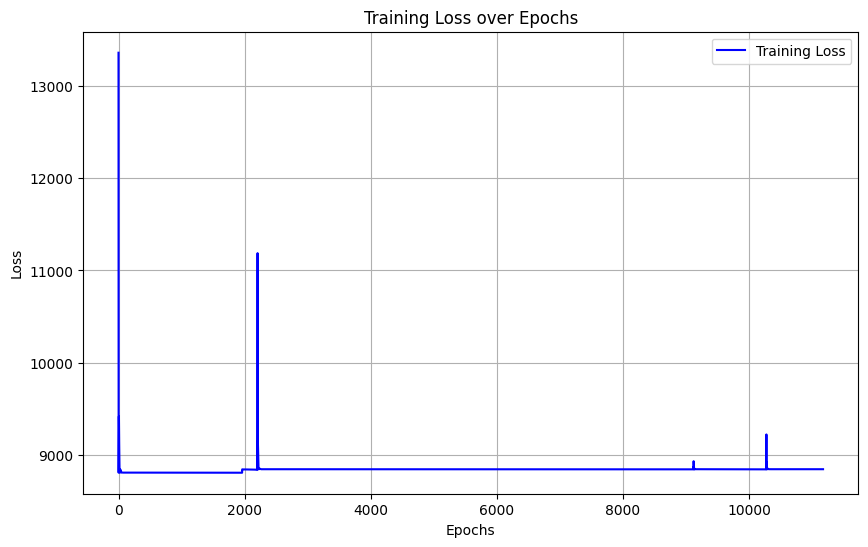

In [116]:
import matplotlib.pyplot as plt

# Plotting the training losses
plt.figure(figsize=(10, 6))
plt.plot(losses, label='Training Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()